$V(x)=\sum_{t=0}^\infty \gamma^t R(x(t))$ \
where  $R(x)=Constant-\|x-x_{goal}\|-Variance>0$ \
and $\gamma=0.5$

# Create Environment

In [113]:
import numpy as np
import matplotlib.pylab as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from tqdm import tqdm

global N

N=50

global M
M=10

global T
global target
T=15
target=np.array([3,2])
global w
w=np.pi*2/23.7

global delta_t
delta_t=T/N

global beta
beta=[0.95,0.975,1,1.025,1.05]

global num_system
num_system=5

In [114]:
def Z(vecs, u, v):
    output=[]
    for i in range(num_system):
        vec=vecs[i]
        x=vec[0]
        y=vec[1]
        theta=vec[2]
        output.append([beta[i]*np.cos(theta)*u,beta[i]*np.sin(theta)*u,beta[i]*v])
    return np.array(output)

#check the correctness of Z
'''
x = np.linspace(0, 6.5, 1001)
plt.plot(x, Z(x))
plt.xlabel('Angle [rad]')
plt.ylabel('Z(theta)')
plt.grid()
plt.show()
'''

"\nx = np.linspace(0, 6.5, 1001)\nplt.plot(x, Z(x))\nplt.xlabel('Angle [rad]')\nplt.ylabel('Z(theta)')\nplt.grid()\nplt.show()\n"

In [115]:
def next_step(vecs,action):  
    u=action[0]
    v=action[1]
   
    for j in range(M):
        vecs_new=[]
        diff=Z(vecs,u,v)
        for i in range(num_system):
            w=vecs[i]+delta_t/M*diff[i]
            '''
            if w[2]>np.pi:
                w[2]-=2*np.pi
            if w[2]<-np.pi:
                w[2]+=2*np.pi
            '''
            vecs_new.append(w)
        vecs=np.array(vecs_new)
    return vecs

def observe(vecs):
    mu_x=0
    mu_y=0
    mu_theta=0
    var_x=0
    var_y=0
    for i in range(num_system):
        mu_x+=vecs[i][0]
        mu_y+=vecs[i][1]
        mu_theta+=vecs[i][2]
        var_x+=vecs[i][0]**2
        var_y+=vecs[i][1]**2
    var_x-=mu_x**2/num_system
    var_y-=mu_y**2/num_system
    
    w=np.array([mu_x,mu_y,mu_theta,var_x,var_y])/num_system
    '''
    if w[2]>np.pi:
        w[2]-=2*np.pi
    if w[2]<-np.pi:
        w[2]+=2*np.pi
    '''
    return w

def reward(obs):
    return max(100-(obs[0]-target[0])**2-(obs[1]-target[1])**2-obs[3]-obs[4],0)

def reward_raw(position):
    r=0
    for i in range(num_system):
        r+=np.linalg.norm(position[i,[0,1]]-target)
    return r



# Learning Settings

In [116]:
global lr
lr=0.7
global eps
eps=0.1
global max_u
max_u=2
global precision
precision=0.0002
global action_set
action_set=np.array([[1,np.pi/4],[-1,np.pi/4],[1,0],[-1,0],[1,-np.pi/4],[-1,-np.pi/4]])

def exploration():
    a=np.random.uniform()
    if a<eps:
        return True
    else:
        return False

def find_max(cand):
    return np.argmax(cand)
    
def decide_u(theta,cand,std,init=False):
    explo=exploration()
    #print("cand",cand.shape)
    #print("std",std.shape)
    if init:
        return(np.random.randint(6)), True
    elif explo:
        return(find_max(std)), True
    else:
        return(find_max(cand)), False
    
def generate_history_pred(gp_list,history):
    cand=[]
    for j in range(len(gp_list)):
        pred=gp_list[j].predict(history.reshape(-1,5), return_std=False).reshape(-1,1)
        if j==0:
            cand=pred
        else:
            cand=np.concatenate((cand,pred),axis=1)
    output=[]
    for j in range(history.shape[0]):
        output.append([np.max(cand[j])])
    return np.array(output)
        
    
def decide_u_exploitation(theta,cand,init=False):
    return find_max(cand)


def trainingset_refine(history_su,history_su_next, history_r, num=1000):
    if history_su.shape[0]<num:
        return history_su, history_su_next, history_r
    else:
        history_su=history_su[-num:-1]
        history_su_next=history_su_next[-num:-1]
        history_r=history_r[-num:-1]
        return history_su,history_su_next,history_r


history_su=[0 for i in range(6)]
history_r=[0 for i in range(6)]
history_su_next=[0 for i in range(6)]
flags=[True for i in range(6)]

# Simulation


In [117]:
num_iter=200

position_result=[]
observation_result=[]
gpr_list=[]

best_r=-10000
best_obs=[]
best_pos=[[] for i in range(5)]
best_u=[]

for iterr in tqdm(range(num_iter)):
    #initialize
    position=np.array([[-2,-2,0],[-2,-2,0],[-2,-2,0],[-2,-2,0],[-2,-2,0]])
    observation=observe(position)
    u_t=[]
    observation_t=[observation]
    position_t=[[] for i in range(5)]
    
    
    for time in range(N+1):
        if iterr==0:
            candidates_u=[]
            std=[]
            u_k, _ = decide_u(observation,np.array(candidates_u),np.array(std),init=True)
            position_new = next_step(position,action_set[u_k])
            observation_new = observe(position_new)
            r = reward(observation_new)
            
            if flags[u_k]:
                history_su[u_k] = observation.reshape(-1,5)
                history_su_next[u_k] = observation_new.reshape(-1,5)  
                history_r[u_k] = np.array([r])
                flags[u_k]=False
            else:
                history_su[u_k] = np.concatenate((history_su[u_k], observation.reshape(-1,5)))
                history_su_next[u_k] = np.concatenate((history_su_next[u_k], observation_new.reshape(-1,5)))
                history_r[u_k] = np.concatenate((history_r[u_k],np.array([r])))
            
            observation=observation_new
            position=position_new
            u_t.append(u_k)
            observation_t.append(observation)
            for i in range(num_system):
                position_t[i].append(position[i])
            
            
        else:            
            candidates_u=[]
            std=[]
            for i in range(6):
                cand, var = gpr_list[i].predict(observation.reshape(-1,5), return_std=True)
                candidates_u.append(cand[0])
                std.append(var[0])
            #print(candidates_u)
            #print(var)
            u_k, explo = decide_u(observation,np.array(candidates_u),np.array(std))
            position_new = next_step(position,action_set[u_k])
            observation_new = observe(position_new)
            r = reward(observation_new)
            #if r>0.1:
            if explo:
                history_su[u_k] = np.concatenate((history_su[u_k], observation.reshape(-1,5)))
                history_su_next[u_k] = np.concatenate((history_su_next[u_k], observation_new.reshape(-1,5)))
                history_r[u_k] = np.concatenate((history_r[u_k],np.array([r])))
            else:
                a=np.random.uniform()
                if a<0.25:
                    history_su[u_k] = np.concatenate((history_su[u_k], observation.reshape(-1,5)))
                    history_su_next[u_k] = np.concatenate((history_su_next[u_k], observation_new.reshape(-1,5)))
                    history_r[u_k] = np.concatenate((history_r[u_k],np.array([r])))
            
            observation=observation_new
            position=position_new
            u_t.append(u_k)
            observation_t.append(observation)
            for i in range(num_system):
                position_t[i].append(position[i])
            
            if time%((N+1)//3+1)==0:
                for i in range(6):
                    history_target=history_r[i].reshape(-1,1)+0.5*generate_history_pred(gpr_list,history_su_next[i])
                    gpr_list[i]=GaussianProcessRegressor(alpha=1e-4).fit(history_su[i], history_target)
                
                '''
                for i in range(6):
                    hist_su, hist_su_next, hist_r = trainingset_refine(history_su[i],history_su_next[i], history_r[i])
                    history_target=hist_r.reshape(-1,1)+0.01*generate_history_pred(gpr_list,hist_su_next)
                    gpr_list[i]=GaussianProcessRegressor(alpha=1e-4).fit(hist_su, history_target)
                '''
     
            
            
    if iterr==0:
        for i in range(6):
            gpr_list.append(GaussianProcessRegressor(alpha=1e-3).fit(history_su[i], history_r[i].reshape(-1,1)))
    else:       
        for i in range(6):
            history_target=history_r[i].reshape(-1,1)+0.5*generate_history_pred(gpr_list,history_su_next[i])
            gpr_list[i]=GaussianProcessRegressor(alpha=1e-3).fit(history_su[i], history_target)
            #print(history_su[i].shape[0])
        '''
        for i in range(6):
            hist_su, hist_su_next, hist_r = trainingset_refine(history_su[i],history_su_next[i], history_r[i])
            history_target=hist_r.reshape(-1,1)+0.01*generate_history_pred(gpr_list,hist_su_next)
            gpr_list[i]=GaussianProcessRegressor(alpha=1e-4).fit(hist_su, history_target)
            print(history_su[i].shape[0])
        '''
            
    print("observation =",observation)
    #print(observation_t)
    position_result.append(position)
    observation_result.append(observation)
    if r>best_r:
        best_r=r
        best_obs=observation_t
        best_pos=position_t
        best_u=u_t
    
    #print(history_su.shape)
    #print(u_t)

  1%|▊                                                                                 | 2/200 [00:00<00:19, 10.26it/s]

observation = [-3.53010874e+00 -1.05719908e+00  2.35619449e-01  3.53939436e-04
  2.62476300e-03]
observation = [-6.59941321  4.79030719 -0.70685835  0.00851873  0.13823925]


  2%|█▋                                                                                | 4/200 [00:00<00:28,  6.82it/s]

observation = [-2.58826786e+00 -1.29639721e+00 -6.93889390e-18  7.42443697e-07
  1.94701255e-03]
observation = [-1.94617466e+00 -1.68455433e+00  2.63677968e-17  6.50056878e-04
  3.87555904e-04]


  2%|██                                                                                | 5/200 [00:00<00:31,  6.27it/s]

observation = [-1.71130188e+00 -1.95630546e+00 -6.93889390e-18  8.89895118e-05
  1.00530783e-05]
observation = [ 1.29934132 -1.77614917 -5.41924733  0.01455809  0.10895719]


  4%|███▎                                                                              | 8/200 [00:01<00:34,  5.54it/s]

observation = [ 0.66430119 -0.66536322 -5.18362788  0.05224185  0.03849502]
observation = [ 3.15340805 -0.08145969 -7.53982237  0.10444181  0.50977713]


  4%|███▋                                                                              | 9/200 [00:01<00:43,  4.36it/s]

observation = [ 0.31138341 -0.9035253  -4.24115008  0.01861034  0.01026584]


  6%|████▍                                                                            | 11/200 [00:02<00:40,  4.72it/s]

observation = [-1.00922129e+00 -1.55507654e+00  2.35619449e-01  1.70066893e-03
  9.37333277e-04]
observation = [-1.30068255 -1.19904847 -0.9424778   0.00242144  0.00199084]


  6%|████▊                                                                            | 12/200 [00:02<00:38,  4.86it/s]

observation = [-5.82115954e-01 -1.24995294e+00 -4.16333634e-18  1.97648846e-03
  2.65143579e-03]
observation = [-0.3479389  -1.31711417 -0.4712389   0.00470827  0.00203138]


  7%|█████▋                                                                           | 14/200 [00:02<00:37,  4.97it/s]

observation = [-0.20343766 -1.33869923 -0.23561945  0.00183098  0.0018729 ]
observation = [ 7.52197919e-01 -7.82137616e-01 -3.29867229e+00  1.22828079e-02
  6.08323681e-04]


  8%|██████▉                                                                          | 17/200 [00:03<00:41,  4.43it/s]

observation = [ 3.06527833e-01 -8.06954704e-01 -3.53429174e+00  3.46852284e-03
  5.11901428e-03]
observation = [-0.15597558 -0.60444967 -1.64933614  0.00657357  0.00610494]


  9%|███████▎                                                                         | 18/200 [00:03<00:40,  4.55it/s]

observation = [4.17999021e-02 8.42117235e-01 2.82743339e+00 2.46912727e-03
 1.17438017e-02]


 10%|████████                                                                         | 20/200 [00:03<00:38,  4.63it/s]

observation = [ 5.72893406e-01 -1.63656948e+00 -4.71238898e-01  6.74934649e-03
  6.42563504e-04]
observation = [4.66515911 4.31111567 4.00553063 0.20118012 0.67103842]


 10%|████████▌                                                                        | 21/200 [00:04<00:38,  4.63it/s]

observation = [4.04717709e+00 2.80260981e-01 3.29867229e+00 3.99984891e-03
 3.37483824e-01]


 11%|████████▉                                                                        | 22/200 [00:04<00:38,  4.61it/s]

observation = [ 4.91373563 -4.50660041  2.59181394  0.30247148  0.12339904]


 12%|█████████▎                                                                       | 23/200 [00:04<00:47,  3.72it/s]

observation = [ 3.35001344e-01 -7.71380473e-01 -2.35619449e+00  3.29355431e-04
  5.94967007e-03]
observation = [ 2.0697826  -1.1852784   2.59181394  0.03598467  0.04517858]


 12%|██████████▏                                                                      | 25/200 [00:05<00:42,  4.07it/s]

observation = [ 1.01560203 -0.32493567  1.88495559  0.00572104  0.01563902]


 13%|██████████▌                                                                      | 26/200 [00:05<00:42,  4.14it/s]

observation = [ 3.10180374 -3.4164495  -0.70685835  0.11747127  0.01084994]


 14%|██████████▉                                                                      | 27/200 [00:05<00:42,  4.08it/s]

observation = [1.05778899 0.19094475 0.70685835 0.00274292 0.01933963]


 14%|███████████▎                                                                     | 28/200 [00:05<00:42,  4.08it/s]

observation = [1.0366504  0.09855296 0.70685835 0.00269381 0.01681697]


 14%|███████████▋                                                                     | 29/200 [00:06<00:46,  3.71it/s]

observation = [0.74601435 0.01570379 1.17809725 0.00217467 0.021067  ]


 15%|████████████▏                                                                    | 30/200 [00:06<00:48,  3.48it/s]

observation = [ 1.20488942  0.2708851  -0.9424778   0.00455339  0.02062958]


 16%|████████████▌                                                                    | 31/200 [00:06<00:48,  3.48it/s]

observation = [ 8.19681499e-02 -3.36624991e-01  1.41371669e+00  8.76530588e-04
  1.18850536e-02]


 16%|████████████▉                                                                    | 32/200 [00:07<00:46,  3.65it/s]

observation = [1.23238827e+00 6.08573977e-01 1.17809725e+00 1.19899402e-03
 2.35359672e-02]


 16%|█████████████▎                                                                   | 33/200 [00:07<00:44,  3.71it/s]

observation = [1.39214173 0.15265922 0.9424778  0.00599902 0.0235525 ]


 17%|█████████████▊                                                                   | 34/200 [00:07<00:44,  3.75it/s]

observation = [ 1.66768072 -1.45728461  0.70685835  0.03043496  0.00748351]


 18%|██████████████▏                                                                  | 35/200 [00:08<00:51,  3.19it/s]

observation = [1.74181956 0.02867467 0.9424778  0.01077218 0.0260481 ]


 18%|██████████████▌                                                                  | 36/200 [00:08<00:50,  3.28it/s]

observation = [8.53532836e-01 2.68610282e-01 1.88495559e+00 1.27753603e-03
 1.83005358e-02]


 18%|██████████████▉                                                                  | 37/200 [00:08<00:48,  3.37it/s]

observation = [1.24082540e+00 8.15747927e-01 1.64933614e+00 1.02611255e-03
 2.97972130e-02]


 19%|███████████████▍                                                                 | 38/200 [00:08<00:48,  3.33it/s]

observation = [1.17868586e+00 7.15193653e-01 1.41371669e+00 8.68691450e-04
 2.56101151e-02]


 20%|███████████████▊                                                                 | 39/200 [00:09<00:54,  2.94it/s]

observation = [1.16840048e+00 7.31503243e-01 9.42477796e-01 7.91270679e-04
 2.59678685e-02]


 20%|████████████████▏                                                                | 40/200 [00:09<00:52,  3.03it/s]

observation = [1.28851431 0.73932201 0.9424778  0.00145805 0.02800676]


 20%|████████████████▌                                                                | 41/200 [00:10<00:50,  3.13it/s]

observation = [1.21235773e+00 8.28803154e-01 1.17809725e+00 9.39145786e-04
 2.95363623e-02]


 21%|█████████████████                                                                | 42/200 [00:10<00:49,  3.18it/s]

observation = [1.37630281e+00 1.41838251e+00 1.64933614e+00 1.21100563e-04
 4.02357235e-02]


 22%|█████████████████▍                                                               | 43/200 [00:10<00:56,  2.78it/s]

observation = [1.88450201 0.77286898 2.12057504 0.00633967 0.04119305]


 22%|█████████████████▊                                                               | 44/200 [00:11<00:55,  2.82it/s]

observation = [1.59906115 0.81020764 1.64933614 0.00338556 0.03651596]


 22%|██████████████████▏                                                              | 45/200 [00:11<00:58,  2.66it/s]

observation = [ 4.56066794 -1.015168    2.35619449  0.10866737  0.16350962]


 23%|██████████████████▋                                                              | 46/200 [00:11<00:55,  2.78it/s]

observation = [ 4.33427248 -0.8670502   1.64933614  0.0866118   0.16144162]


 24%|███████████████████                                                              | 47/200 [00:12<00:55,  2.78it/s]

observation = [1.51373515e+00 1.30288247e+00 2.35619449e+00 5.60723683e-04
 3.85585692e-02]


 24%|███████████████████▍                                                             | 48/200 [00:12<00:53,  2.82it/s]

observation = [ 3.82795183 -0.32338226  2.12057504  0.04988158  0.12982704]


 24%|███████████████████▊                                                             | 49/200 [00:13<01:02,  2.43it/s]

observation = [ 3.87702403 -0.24958204  2.35619449  0.05434037  0.13217493]


 25%|████████████████████▎                                                            | 50/200 [00:13<00:58,  2.55it/s]

observation = [ 3.94505428 -0.03592259  2.59181394  0.05218082  0.1494408 ]


 26%|████████████████████▋                                                            | 51/200 [00:13<00:57,  2.59it/s]

observation = [2.35772413 0.71023103 3.06305284 0.01101597 0.06608948]


 26%|█████████████████████                                                            | 52/200 [00:14<01:02,  2.37it/s]

observation = [ 2.79593298 -0.12910528  1.88495559  0.03553524  0.05778462]


 26%|█████████████████████▍                                                           | 53/200 [00:14<00:59,  2.48it/s]

observation = [2.85074283 0.38474188 2.82743339 0.02131485 0.08594773]


 27%|█████████████████████▊                                                           | 54/200 [00:15<00:57,  2.52it/s]

observation = [2.86592483 0.61963045 3.29867229 0.01504083 0.0979236 ]


 28%|██████████████████████▎                                                          | 55/200 [00:15<01:07,  2.16it/s]

observation = [2.37255997 0.53186439 2.82743339 0.01371973 0.05992776]


 28%|██████████████████████▋                                                          | 56/200 [00:16<01:03,  2.26it/s]

observation = [2.96757577 0.39610372 3.29867229 0.02333888 0.09036198]


 28%|███████████████████████                                                          | 57/200 [00:16<01:01,  2.31it/s]

observation = [1.66912879e+00 1.38844660e+00 1.41371669e+00 1.12455982e-03
 4.49880897e-02]


 29%|███████████████████████▍                                                         | 58/200 [00:17<01:06,  2.14it/s]

observation = [2.24569619 0.56979393 1.88495559 0.01001976 0.04434235]


 30%|███████████████████████▉                                                         | 59/200 [00:17<01:04,  2.20it/s]

observation = [1.78366161e+00 1.82504562e+00 1.41371669e+00 1.54422730e-04
 5.12196627e-02]


 30%|████████████████████████▎                                                        | 60/200 [00:18<01:07,  2.09it/s]

observation = [1.71161411e+00 1.90877537e+00 1.41371669e+00 4.93636070e-05
 5.24763924e-02]


 30%|████████████████████████▋                                                        | 61/200 [00:18<01:07,  2.05it/s]

observation = [1.54906097e+00 1.92182898e+00 1.64933614e+00 7.07333073e-05
 4.90139060e-02]


 31%|█████████████████████████                                                        | 62/200 [00:18<01:05,  2.10it/s]

observation = [2.98117452 0.38697559 2.82743339 0.02786208 0.07070117]


 32%|█████████████████████████▌                                                       | 63/200 [00:19<01:09,  1.98it/s]

observation = [2.95604014 0.20810928 2.82743339 0.02682198 0.04520529]


 32%|█████████████████████████▉                                                       | 64/200 [00:20<01:07,  2.02it/s]

observation = [1.70385808e+00 1.82672233e+00 1.17809725e+00 6.28925705e-05
 4.87033149e-02]


 32%|██████████████████████████▎                                                      | 65/200 [00:20<01:04,  2.08it/s]

observation = [1.69414470e+00 1.75815060e+00 1.41371669e+00 7.98826980e-05
 4.55935398e-02]


 33%|██████████████████████████▋                                                      | 66/200 [00:21<01:06,  2.00it/s]

observation = [1.81418176e+00 1.77761525e+00 9.42477796e-01 2.50728074e-04
 4.93664776e-02]


 34%|███████████████████████████▏                                                     | 67/200 [00:21<01:05,  2.03it/s]

observation = [1.68474303e+00 1.90759610e+00 1.64933614e+00 3.08356361e-05
 5.18546703e-02]


 34%|███████████████████████████▌                                                     | 68/200 [00:22<01:07,  1.96it/s]

observation = [1.66129426e+00 2.06581816e+00 1.64933614e+00 3.14082607e-05
 5.70387923e-02]


 34%|███████████████████████████▉                                                     | 69/200 [00:22<01:07,  1.95it/s]

observation = [1.95128656e+00 2.24866160e+00 9.42477796e-01 8.40794290e-05
 5.80209916e-02]


 35%|████████████████████████████▎                                                    | 70/200 [00:23<01:07,  1.93it/s]

observation = [1.95334862e+00 1.91597861e+00 1.41371669e+00 6.06269629e-04
 5.86633737e-02]


 36%|████████████████████████████▊                                                    | 71/200 [00:23<01:13,  1.76it/s]

observation = [1.81452894e+00 1.76105818e+00 1.41371669e+00 2.79832508e-04
 4.85923634e-02]


 36%|█████████████████████████████▏                                                   | 72/200 [00:24<01:10,  1.82it/s]

observation = [1.88756216e+00 1.77613315e+00 1.17809725e+00 4.91296774e-04
 5.08524077e-02]


 36%|█████████████████████████████▌                                                   | 73/200 [00:25<01:19,  1.60it/s]

observation = [1.78665312e+00 2.08516769e+00 1.17809725e+00 9.61333588e-05
 6.19527382e-02]


 37%|█████████████████████████████▉                                                   | 74/200 [00:25<01:15,  1.67it/s]

observation = [2.18914015e+00 2.32884163e+00 1.17809725e+00 1.75706493e-04
 6.68077287e-02]


 38%|██████████████████████████████▍                                                  | 75/200 [00:26<01:16,  1.64it/s]

observation = [2.19457151e+00 2.32275824e+00 1.17809725e+00 1.90578040e-04
 6.66394939e-02]


 38%|██████████████████████████████▊                                                  | 76/200 [00:26<01:17,  1.61it/s]

observation = [2.30355861e+00 2.31642831e+00 1.41371669e+00 4.59258154e-04
 6.94239678e-02]


 38%|███████████████████████████████▏                                                 | 77/200 [00:27<01:13,  1.68it/s]

observation = [2.15613358e+00 2.36088919e+00 1.17809725e+00 1.04838765e-04
 6.75603279e-02]


 39%|███████████████████████████████▌                                                 | 78/200 [00:28<01:12,  1.68it/s]

observation = [1.66494311e+00 2.04016754e+00 1.17809725e+00 2.89205622e-05
 5.73603058e-02]


 40%|███████████████████████████████▉                                                 | 79/200 [00:28<01:17,  1.57it/s]

observation = [2.13845811e+00 2.37218689e+00 1.17809725e+00 8.54123330e-05
 6.75303415e-02]


 40%|████████████████████████████████▍                                                | 80/200 [00:29<01:15,  1.58it/s]

observation = [2.18850242e+00 2.49027390e+00 9.42477796e-01 1.33271812e-04
 7.44357206e-02]


 40%|████████████████████████████████▊                                                | 81/200 [00:30<01:21,  1.45it/s]

observation = [2.10147982e+00 2.13665748e+00 9.42477796e-01 5.38478648e-05
 5.77328278e-02]


 41%|█████████████████████████████████▏                                               | 82/200 [00:30<01:19,  1.49it/s]

observation = [2.17721476e+00 1.76587649e+00 1.41371669e+00 2.06481647e-03
 5.69388717e-02]


 42%|█████████████████████████████████▌                                               | 83/200 [00:31<01:22,  1.41it/s]

observation = [2.08300132e+00 2.43182579e+00 9.42477796e-01 3.47512624e-05
 6.89745507e-02]


 42%|██████████████████████████████████                                               | 84/200 [00:32<01:20,  1.43it/s]

observation = [2.15615105e+00 2.50271503e+00 9.42477796e-01 7.61087791e-05
 7.45336746e-02]


 42%|██████████████████████████████████▍                                              | 85/200 [00:33<01:24,  1.36it/s]

observation = [2.03880841e+00 2.11391256e+00 7.06858347e-01 3.14583616e-05
 5.41884501e-02]


 43%|██████████████████████████████████▊                                              | 86/200 [00:33<01:26,  1.32it/s]

observation = [2.28925638 1.05369067 1.41371669 0.00805457 0.04535751]


 44%|███████████████████████████████████▏                                             | 87/200 [00:34<01:26,  1.30it/s]

observation = [2.46128034e+00 2.22943567e+00 7.06858347e-01 1.35212590e-03
 6.89391620e-02]


 44%|███████████████████████████████████▋                                             | 88/200 [00:35<01:29,  1.25it/s]

observation = [2.11398202e+00 2.17656127e+00 1.17809725e+00 7.17361768e-05
 5.89511415e-02]


 44%|████████████████████████████████████                                             | 89/200 [00:36<01:25,  1.30it/s]

observation = [2.41269105e+00 2.23392561e+00 9.42477796e-01 1.06084780e-03
 6.79715451e-02]


 45%|████████████████████████████████████▍                                            | 90/200 [00:37<01:29,  1.22it/s]

observation = [2.24594560e+00 2.45535685e+00 7.06858347e-01 2.58647480e-04
 7.44168029e-02]


 46%|████████████████████████████████████▊                                            | 91/200 [00:38<01:32,  1.18it/s]

observation = [2.54834078e+00 2.20112059e+00 9.42477796e-01 1.96274511e-03
 6.98539255e-02]


 46%|█████████████████████████████████████▎                                           | 92/200 [00:39<01:32,  1.17it/s]

observation = [2.60499445e+00 2.13840504e+00 1.17809725e+00 2.50622636e-03
 6.82305968e-02]


 46%|█████████████████████████████████████▋                                           | 93/200 [00:39<01:33,  1.15it/s]

observation = [3.11880164 0.57998369 1.41371669 0.03033398 0.06241202]


 47%|██████████████████████████████████████                                           | 94/200 [00:40<01:33,  1.13it/s]

observation = [2.53028856e+00 2.25392486e+00 9.42477796e-01 1.77790149e-03
 7.19065891e-02]


 48%|██████████████████████████████████████▍                                          | 95/200 [00:41<01:32,  1.13it/s]

observation = [2.37988399e+00 2.25339262e+00 1.17809725e+00 8.54455137e-04
 6.81877301e-02]


 48%|██████████████████████████████████████▉                                          | 96/200 [00:42<01:33,  1.11it/s]

observation = [2.31172227e+00 2.28873616e+00 9.42477796e-01 5.67150454e-04
 6.78750789e-02]


 48%|███████████████████████████████████████▎                                         | 97/200 [00:43<01:35,  1.07it/s]

observation = [2.37829927 1.44855223 2.35619449 0.0051867  0.04796074]


 49%|███████████████████████████████████████▋                                         | 98/200 [00:44<01:32,  1.11it/s]

observation = [2.17783778 1.25941954 2.12057504 0.00579916 0.03600761]


 50%|████████████████████████████████████████                                         | 99/200 [00:45<01:35,  1.05it/s]

observation = [2.28405561 1.63124794 1.64933614 0.00291129 0.05458594]


 50%|████████████████████████████████████████                                        | 100/200 [00:46<01:38,  1.02it/s]

observation = [2.39235816e+00 2.42009438e+00 9.42477796e-01 8.43111538e-04
 7.61715787e-02]


 50%|████████████████████████████████████████▍                                       | 101/200 [00:47<01:37,  1.01it/s]

observation = [2.18120968e+00 2.61483170e+00 1.17809725e+00 6.51234544e-05
 8.12883537e-02]


 51%|████████████████████████████████████████▊                                       | 102/200 [00:48<01:36,  1.02it/s]

observation = [2.23275475 1.45788779 2.12057504 0.00362819 0.04482107]


 52%|█████████████████████████████████████████▏                                      | 103/200 [00:49<01:37,  1.00s/it]

observation = [2.29170522 1.5569717  1.88495559 0.00352126 0.05063045]


 52%|█████████████████████████████████████████▌                                      | 104/200 [00:50<01:39,  1.04s/it]

observation = [2.61902875 1.54401954 2.12057504 0.00681777 0.05840464]


 52%|██████████████████████████████████████████                                      | 105/200 [00:51<01:41,  1.07s/it]

observation = [2.52697371 1.55501513 2.12057504 0.00590296 0.05631811]


 53%|██████████████████████████████████████████▍                                     | 106/200 [00:53<01:42,  1.09s/it]

observation = [2.55727921e+00 2.17446329e+00 9.42477796e-01 2.07568097e-03
 6.87381118e-02]


 54%|██████████████████████████████████████████▊                                     | 107/200 [00:54<01:42,  1.10s/it]

observation = [2.57763344 1.57118466 1.88495559 0.00609589 0.05881507]


 54%|███████████████████████████████████████████▏                                    | 108/200 [00:55<01:42,  1.11s/it]

observation = [2.44004667e+00 2.19551307e+00 1.64933614e+00 1.30899034e-03
 6.65901392e-02]


 55%|███████████████████████████████████████████▌                                    | 109/200 [00:56<01:40,  1.10s/it]

observation = [2.77686317e+00 2.78135451e+00 7.06858347e-01 8.59383662e-04
 8.74679336e-02]


 55%|████████████████████████████████████████████                                    | 110/200 [00:57<01:42,  1.13s/it]

observation = [2.50826857e+00 2.18809827e+00 1.17809725e+00 1.69920170e-03
 6.81706353e-02]


 56%|████████████████████████████████████████████▍                                   | 111/200 [00:58<01:37,  1.10s/it]

observation = [2.54463151e+00 2.12387053e+00 1.64933614e+00 2.10849160e-03
 6.58623648e-02]


 56%|████████████████████████████████████████████▊                                   | 112/200 [00:59<01:39,  1.13s/it]

observation = [2.44198614e+00 2.13500980e+00 1.17809725e+00 1.29020941e-03
 6.43212813e-02]


 56%|█████████████████████████████████████████████▏                                  | 113/200 [01:01<01:40,  1.16s/it]

observation = [2.00201515e+00 2.01832316e+00 1.64933614e+00 7.38628650e-04
 6.45531642e-02]


 57%|█████████████████████████████████████████████▌                                  | 114/200 [01:02<01:41,  1.18s/it]

observation = [2.58525167e+00 2.12607687e+00 1.17809725e+00 2.39819876e-03
 6.70395953e-02]


 57%|██████████████████████████████████████████████                                  | 115/200 [01:03<01:39,  1.17s/it]

observation = [2.80497082 1.64730681 2.12057504 0.00806326 0.06906348]


 58%|██████████████████████████████████████████████▍                                 | 116/200 [01:04<01:41,  1.21s/it]

observation = [2.56245192e+00 2.10903938e+00 1.64933614e+00 2.27971045e-03
 6.55780183e-02]


 58%|██████████████████████████████████████████████▊                                 | 117/200 [01:06<01:43,  1.24s/it]

observation = [2.47399887e+00 2.24551644e+00 7.06858347e-01 1.41396108e-03
 7.00462108e-02]


 59%|███████████████████████████████████████████████▏                                | 118/200 [01:07<01:43,  1.27s/it]

observation = [2.63097879e+00 2.34138665e+00 9.42477796e-01 2.21049035e-03
 7.97645124e-02]


 60%|███████████████████████████████████████████████▌                                | 119/200 [01:08<01:46,  1.31s/it]

observation = [2.47945622e+00 2.21783901e+00 7.06858347e-01 1.47921639e-03
 6.88355320e-02]


 60%|████████████████████████████████████████████████                                | 120/200 [01:10<01:47,  1.34s/it]

observation = [2.69007376e+00 2.79329199e+00 7.06858347e-01 4.91679278e-04
 8.55757073e-02]


 60%|████████████████████████████████████████████████▍                               | 121/200 [01:11<01:49,  1.38s/it]

observation = [3.48260258 2.84385902 0.4712389  0.00369971 0.09198368]


 61%|████████████████████████████████████████████████▊                               | 122/200 [01:13<01:47,  1.38s/it]

observation = [2.82205813e+00 2.71777798e+00 9.42477796e-01 1.15433720e-03
 8.53000831e-02]


 62%|█████████████████████████████████████████████████▏                              | 123/200 [01:14<01:44,  1.35s/it]

observation = [2.54596924e+00 1.99787986e+00 1.64933614e+00 2.34677980e-03
 6.00462286e-02]


 62%|█████████████████████████████████████████████████▌                              | 124/200 [01:15<01:45,  1.39s/it]

observation = [2.38961991e+00 2.13357624e+00 9.42477796e-01 9.93455131e-04
 6.30016152e-02]


 62%|██████████████████████████████████████████████████                              | 125/200 [01:17<01:43,  1.38s/it]

observation = [2.75185538e+00 2.68075310e+00 9.42477796e-01 8.35250630e-04
 8.13080737e-02]


 63%|██████████████████████████████████████████████████▍                             | 126/200 [01:18<01:45,  1.43s/it]

observation = [2.56248805e+00 2.12303040e+00 1.17809725e+00 2.17009962e-03
 6.64768090e-02]


 64%|██████████████████████████████████████████████████▊                             | 127/200 [01:20<01:42,  1.41s/it]

observation = [2.55578192e+00 2.10400270e+00 1.64933614e+00 2.22025308e-03
 6.51925203e-02]


 64%|███████████████████████████████████████████████████▏                            | 128/200 [01:21<01:47,  1.49s/it]

observation = [2.52266509e+00 2.10045945e+00 1.88495559e+00 2.05941877e-03
 6.40736256e-02]


 64%|███████████████████████████████████████████████████▌                            | 129/200 [01:23<01:48,  1.52s/it]

observation = [2.35627118e+00 2.54441052e+00 7.06858347e-01 5.84413414e-04
 8.16821780e-02]


 65%|████████████████████████████████████████████████████                            | 130/200 [01:24<01:48,  1.56s/it]

observation = [2.53398485e+00 2.14716079e+00 9.42477796e-01 1.93009107e-03
 6.68702729e-02]


 66%|████████████████████████████████████████████████████▍                           | 131/200 [01:26<01:53,  1.65s/it]

observation = [2.38916748e+00 2.33371570e+00 9.42477796e-01 8.66039193e-04
 7.21120540e-02]


 66%|████████████████████████████████████████████████████▊                           | 132/200 [01:28<01:52,  1.65s/it]

observation = [1.88352141e+00 2.69135900e+00 7.06858347e-01 3.73945201e-04
 7.65114500e-02]


 66%|█████████████████████████████████████████████████████▏                          | 133/200 [01:30<01:51,  1.66s/it]

observation = [2.63301209 2.06474943 1.41371669 0.00286354 0.06544496]


 67%|█████████████████████████████████████████████████████▌                          | 134/200 [01:31<01:49,  1.67s/it]

observation = [2.82645835 1.59960584 2.35619449 0.0085187  0.06721318]


 68%|██████████████████████████████████████████████████████                          | 135/200 [01:33<01:49,  1.68s/it]

observation = [2.84969522 1.53587688 2.35619449 0.0091614  0.06473144]


 68%|██████████████████████████████████████████████████████▍                         | 136/200 [01:35<01:48,  1.69s/it]

observation = [2.84089828 1.79578738 1.17809725 0.00545134 0.05860962]


 68%|██████████████████████████████████████████████████████▊                         | 137/200 [01:37<01:47,  1.71s/it]

observation = [2.76663433 1.93288418 0.9424778  0.00440502 0.06265568]


 69%|███████████████████████████████████████████████████████▏                        | 138/200 [01:38<01:44,  1.69s/it]

observation = [2.80034047 1.91232194 0.9424778  0.00480688 0.06260459]


 70%|███████████████████████████████████████████████████████▌                        | 139/200 [01:40<01:43,  1.69s/it]

observation = [2.78126102 1.92690312 0.9424778  0.0045879  0.06270989]


 70%|████████████████████████████████████████████████████████                        | 140/200 [01:42<01:44,  1.75s/it]

observation = [2.86849448 1.85792044 0.9424778  0.00576983 0.06170323]


 70%|████████████████████████████████████████████████████████▍                       | 141/200 [01:44<01:48,  1.85s/it]

observation = [2.57671228e+00 1.97655733e+00 4.71238898e-01 2.49027420e-03
 6.00875631e-02]


 71%|████████████████████████████████████████████████████████▊                       | 142/200 [01:46<01:47,  1.85s/it]

observation = [2.60531572e+00 2.08477304e+00 2.35619449e-01 2.54445228e-03
 6.59107416e-02]


 72%|█████████████████████████████████████████████████████████▏                      | 143/200 [01:48<01:46,  1.87s/it]

observation = [2.63847714 2.07075349 0.4712389  0.00290299 0.06581291]


 72%|█████████████████████████████████████████████████████████▌                      | 144/200 [01:50<01:58,  2.11s/it]

observation = [2.63255287 1.68313975 1.88495559 0.00524342 0.06591165]


 72%|██████████████████████████████████████████████████████████                      | 145/200 [01:53<01:58,  2.15s/it]

observation = [2.60915673 2.00955149 0.4712389  0.00274423 0.06224685]


 73%|██████████████████████████████████████████████████████████▍                     | 146/200 [01:55<01:59,  2.22s/it]

observation = [2.83207195 1.9290169  1.17809725 0.00517636 0.064057  ]


 74%|██████████████████████████████████████████████████████████▊                     | 147/200 [01:57<01:56,  2.20s/it]

observation = [2.81181533e+00 2.30221813e+00 9.42477796e-01 1.21407956e-03
 6.70790208e-02]


 74%|███████████████████████████████████████████████████████████▏                    | 148/200 [01:59<01:57,  2.26s/it]

observation = [2.66530385 1.98389442 2.12057504 0.00351303 0.06215053]


 74%|███████████████████████████████████████████████████████████▌                    | 149/200 [02:02<01:58,  2.33s/it]

observation = [2.66428894 2.03608052 1.17809725 0.00317539 0.06493295]


 75%|████████████████████████████████████████████████████████████                    | 150/200 [02:04<01:57,  2.36s/it]

observation = [2.97385162e+00 2.57812252e+00 7.06858347e-01 2.35343143e-03
 8.22290505e-02]


 76%|████████████████████████████████████████████████████████████▍                   | 151/200 [02:07<02:03,  2.51s/it]

observation = [2.78024245 1.86927232 0.70685835 0.00461965 0.0603328 ]


 76%|████████████████████████████████████████████████████████████▊                   | 152/200 [02:10<01:58,  2.48s/it]

observation = [2.74033873 1.99690623 1.41371669 0.00402315 0.06492823]


 76%|█████████████████████████████████████████████████████████████▏                  | 153/200 [02:12<01:56,  2.47s/it]

observation = [2.80014545 1.93366495 1.41371669 0.00476545 0.06356131]


 77%|█████████████████████████████████████████████████████████████▌                  | 154/200 [02:15<01:56,  2.54s/it]

observation = [2.97749911 1.958006   2.12057504 0.00571933 0.07069967]


 78%|██████████████████████████████████████████████████████████████                  | 155/200 [02:18<01:58,  2.63s/it]

observation = [2.88672755 1.93833681 1.88495559 0.00568516 0.066059  ]


 78%|██████████████████████████████████████████████████████████████▍                 | 156/200 [02:20<01:54,  2.60s/it]

observation = [2.81134424 1.32343467 0.9424778  0.0103323  0.05337868]


 78%|██████████████████████████████████████████████████████████████▊                 | 157/200 [02:23<01:59,  2.77s/it]

observation = [3.05990757 2.48337032 0.70685835 0.00324569 0.07965378]


 79%|███████████████████████████████████████████████████████████████▏                | 158/200 [02:26<01:55,  2.76s/it]

observation = [2.97849416 1.79439299 1.64933614 0.00715158 0.06191459]


 80%|███████████████████████████████████████████████████████████████▌                | 159/200 [02:29<02:00,  2.95s/it]

observation = [2.97871283 1.89042671 1.41371669 0.00677762 0.0665726 ]


 80%|████████████████████████████████████████████████████████████████                | 160/200 [02:32<01:57,  2.94s/it]

observation = [2.68131445e+00 2.59480932e+00 7.06858347e-01 6.36879363e-04
 7.47007796e-02]


 80%|████████████████████████████████████████████████████████████████▍               | 161/200 [02:35<01:54,  2.94s/it]

observation = [2.82053993 2.0211376  1.88495559 0.00500258 0.06716778]


 81%|████████████████████████████████████████████████████████████████▊               | 162/200 [02:38<01:51,  2.93s/it]

observation = [2.68879449 1.88102435 1.88495559 0.00400141 0.05797874]


 82%|█████████████████████████████████████████████████████████████████▏              | 163/200 [02:41<01:49,  2.97s/it]

observation = [3.18573195 2.3103045  0.23561945 0.00485947 0.07437148]


 82%|█████████████████████████████████████████████████████████████████▌              | 164/200 [02:44<01:49,  3.03s/it]

observation = [2.94085702 1.7808054  1.64933614 0.00686658 0.06002532]


 82%|██████████████████████████████████████████████████████████████████              | 165/200 [02:48<01:47,  3.06s/it]

observation = [2.99790998 1.80585083 1.17809725 0.0076271  0.06251573]


 83%|██████████████████████████████████████████████████████████████████▍             | 166/200 [02:51<01:43,  3.03s/it]

observation = [2.93904931 1.79009872 0.9424778  0.00685482 0.06035283]


 84%|██████████████████████████████████████████████████████████████████▊             | 167/200 [02:54<01:39,  3.03s/it]

observation = [3.13317098 2.29123985 1.17809725 0.00408977 0.07304968]


 84%|███████████████████████████████████████████████████████████████████▏            | 168/200 [02:57<01:38,  3.07s/it]

observation = [3.29779481 2.25244253 0.4712389  0.00639234 0.07443212]


 84%|███████████████████████████████████████████████████████████████████▌            | 169/200 [03:00<01:37,  3.16s/it]

observation = [2.94288939 1.78435212 0.9424778  0.0069989  0.05977834]


 85%|████████████████████████████████████████████████████████████████████            | 170/200 [03:03<01:36,  3.21s/it]

observation = [3.2955713  2.26604932 0.9424778  0.00630278 0.07512575]


 86%|████████████████████████████████████████████████████████████████████▍           | 171/200 [03:07<01:33,  3.22s/it]

observation = [2.69194206 2.08246107 0.4712389  0.0034592  0.06734961]


 86%|████████████████████████████████████████████████████████████████████▊           | 172/200 [03:10<01:33,  3.33s/it]

observation = [3.29054537 2.21698732 0.23561945 0.0063638  0.07250141]


 86%|█████████████████████████████████████████████████████████████████████▏          | 173/200 [03:14<01:31,  3.39s/it]

observation = [2.91721303 1.79768648 0.9424778  0.00652906 0.06018106]


 87%|█████████████████████████████████████████████████████████████████████▌          | 174/200 [03:17<01:29,  3.45s/it]

observation = [3.22977718 2.36994858 0.23561945 0.00534174 0.07825395]


 88%|██████████████████████████████████████████████████████████████████████          | 175/200 [03:21<01:26,  3.46s/it]

observation = [3.90566588 1.79653379 3.29867229 0.01356564 0.11686247]


 88%|██████████████████████████████████████████████████████████████████████▍         | 176/200 [03:24<01:23,  3.49s/it]

observation = [2.75626926 1.88778504 0.9424778  0.00437107 0.06039757]


 88%|██████████████████████████████████████████████████████████████████████▊         | 177/200 [03:28<01:20,  3.51s/it]

observation = [2.75752389 1.93749527 0.23561945 0.00429888 0.06263013]


 89%|███████████████████████████████████████████████████████████████████████▏        | 178/200 [03:32<01:17,  3.54s/it]

observation = [2.89325633 1.83213103 0.9424778  0.00614866 0.06112038]


 90%|███████████████████████████████████████████████████████████████████████▌        | 179/200 [03:35<01:14,  3.56s/it]

observation = [2.88948148 1.83358455 2.35619449 0.00620159 0.0611072 ]


 90%|████████████████████████████████████████████████████████████████████████        | 180/200 [03:39<01:12,  3.63s/it]

observation = [3.18274714 2.34631316 0.9424778  0.00475964 0.07612263]


 90%|████████████████████████████████████████████████████████████████████████▍       | 181/200 [03:43<01:10,  3.71s/it]

observation = [3.06181745 2.52383215 0.4712389  0.00326446 0.08132461]


 91%|████████████████████████████████████████████████████████████████████████▊       | 182/200 [03:47<01:06,  3.71s/it]

observation = [2.78609506 1.92116428 0.23561945 0.00463315 0.06264411]


 92%|█████████████████████████████████████████████████████████████████████████▏      | 183/200 [03:50<01:03,  3.75s/it]

observation = [3.06657727 1.5492421  1.17809725 0.00920544 0.05330148]


 92%|█████████████████████████████████████████████████████████████████████████▌      | 184/200 [03:55<01:02,  3.90s/it]

observation = [2.77025092 1.95580976 0.23561945 0.00439925 0.06383353]


 92%|██████████████████████████████████████████████████████████████████████████      | 185/200 [03:59<00:58,  3.92s/it]

observation = [2.77654211 1.93273582 0.70685835 0.0044995  0.06296114]


 93%|██████████████████████████████████████████████████████████████████████████▍     | 186/200 [04:03<00:57,  4.13s/it]

observation = [2.88111794 1.77388626 1.41371669 0.00606171 0.0584441 ]


 94%|██████████████████████████████████████████████████████████████████████████▊     | 187/200 [04:08<00:55,  4.29s/it]

observation = [3.21212783 2.21054704 0.9424778  0.00524779 0.07066642]


 94%|███████████████████████████████████████████████████████████████████████████▏    | 188/200 [04:12<00:50,  4.24s/it]

observation = [2.90194535 1.8352162  2.59181394 0.006574   0.06168816]


 94%|███████████████████████████████████████████████████████████████████████████▌    | 189/200 [04:16<00:46,  4.22s/it]

observation = [2.83257387 1.82391823 0.4712389  0.00529753 0.05966135]


 95%|████████████████████████████████████████████████████████████████████████████    | 190/200 [04:21<00:43,  4.40s/it]

observation = [3.01434553e+00 2.41360179e+00 1.41371669e+00 2.96357730e-03
 7.48086584e-02]


 96%|████████████████████████████████████████████████████████████████████████████▍   | 191/200 [04:26<00:40,  4.49s/it]

observation = [2.87358688 1.82861257 1.41371669 0.00590936 0.06047806]


 96%|████████████████████████████████████████████████████████████████████████████▊   | 192/200 [04:30<00:35,  4.50s/it]

observation = [2.73387469 1.88880562 1.17809725 0.00412062 0.05992191]


 96%|█████████████████████████████████████████████████████████████████████████████▏  | 193/200 [04:35<00:31,  4.47s/it]

observation = [2.88033926 1.79782585 1.41371669 0.00603344 0.05933305]


 97%|█████████████████████████████████████████████████████████████████████████████▌  | 194/200 [04:39<00:27,  4.53s/it]

observation = [3.2561532  2.17710933 0.4712389  0.0058599  0.07019818]


 98%|██████████████████████████████████████████████████████████████████████████████  | 195/200 [04:44<00:23,  4.60s/it]

observation = [3.039437   2.31157477 1.41371669 0.00317631 0.07142758]


 98%|██████████████████████████████████████████████████████████████████████████████▍ | 196/200 [04:49<00:18,  4.60s/it]

observation = [2.82945829 1.83886468 0.4712389  0.00524549 0.06020249]


 98%|██████████████████████████████████████████████████████████████████████████████▊ | 197/200 [04:53<00:13,  4.49s/it]

observation = [3.05525415 1.62337941 1.41371669 0.00885716 0.05608621]


 99%|███████████████████████████████████████████████████████████████████████████████▏| 198/200 [04:57<00:08,  4.39s/it]

observation = [3.12198076 2.32787066 0.23561945 0.00417481 0.07332409]


100%|███████████████████████████████████████████████████████████████████████████████▌| 199/200 [05:01<00:04,  4.27s/it]

observation = [3.00862715 2.0072451  2.82743339 0.00557053 0.07310122]


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [05:05<00:00,  1.53s/it]

observation = [2.92472603 1.89671915 1.88495559 0.00620183 0.06522333]


# Results

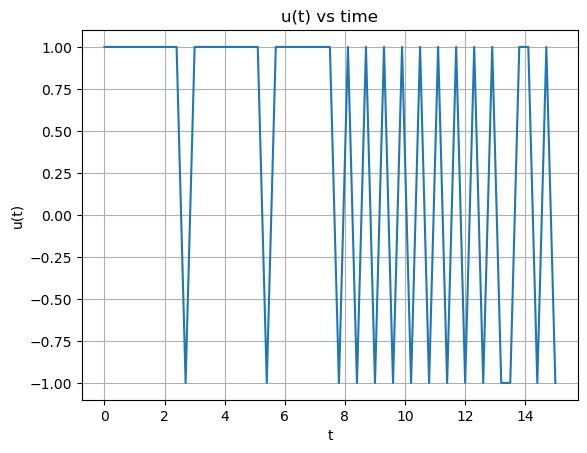

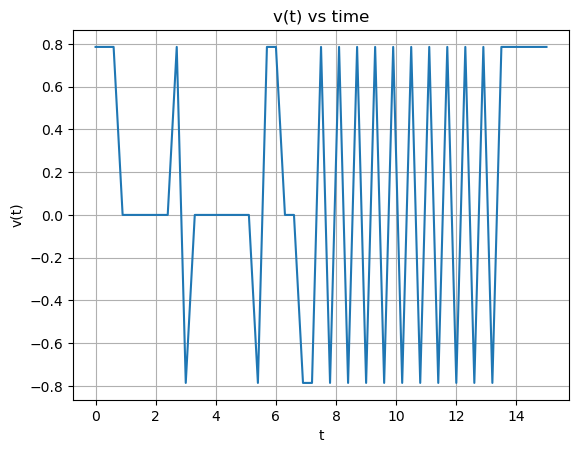

In [118]:
u=[2*(0.5-i%2) for i in u_t]
v=[(1-i//2)*np.pi/4 for i in u_t]

x = np.linspace(0, T, N+1)
plt.plot(x, u)
plt.xlabel('t')
plt.ylabel('u(t)')
plt.title("u(t) vs time")
plt.grid()
plt.show()

x = np.linspace(0, T, N+1)
plt.plot(x, v)
plt.xlabel('t')
plt.ylabel('v(t)')
plt.title("v(t) vs time")
plt.grid()
plt.show()

## Last Trajectory


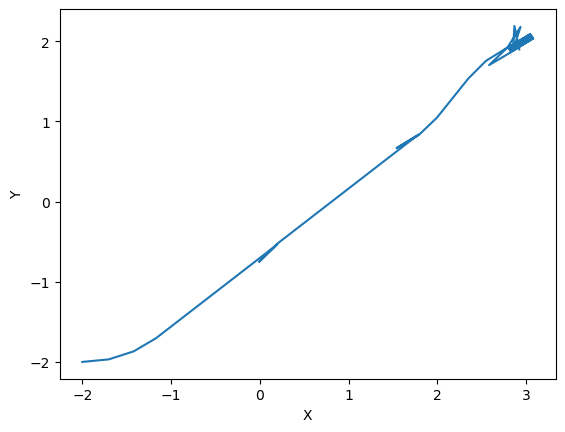

In [119]:
obs=np.array(observation_t)
obs=obs[:,[0,1]]
plt.plot(obs[:,0],obs[:,1])
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

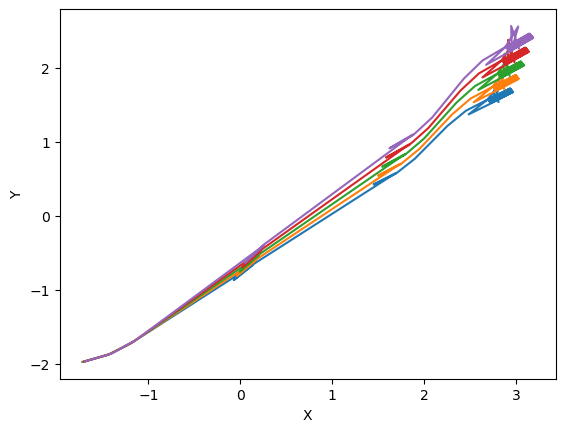

1.2804634223031295


In [120]:
pos=[]
for i in range(num_system):
    obs=np.array(position_t[i])
    obs=obs[:,[0,1]]
    plt.plot(obs[:,0],obs[:,1])
    pos.append(obs[-1])
plt.xlabel('X')
plt.ylabel('Y')
plt.show()
print(reward_raw(np.array(pos)))

## Best Trajectory

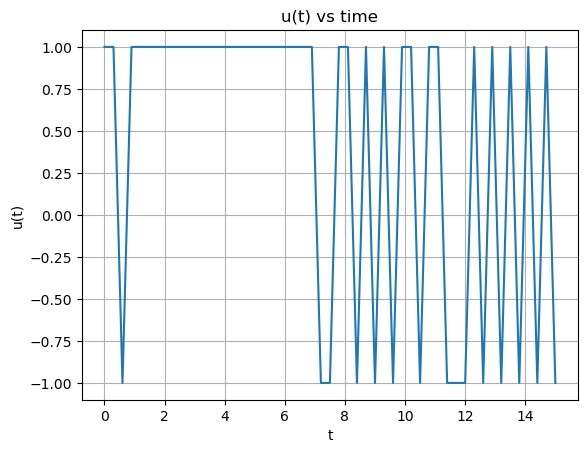

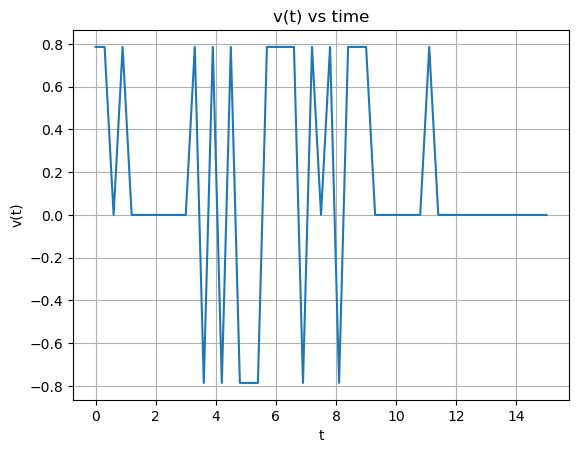

In [121]:
u=[2*(0.5-i%2) for i in best_u]
v=[(1-i//2)*np.pi/4 for i in best_u]

x = np.linspace(0, T, N+1)
plt.plot(x, u)
plt.xlabel('t')
plt.ylabel('u(t)')
plt.title("u(t) vs time")
plt.grid()
plt.show()

x = np.linspace(0, T, N+1)
plt.plot(x, v)
plt.xlabel('t')
plt.ylabel('v(t)')
plt.title("v(t) vs time")
plt.grid()
plt.show()

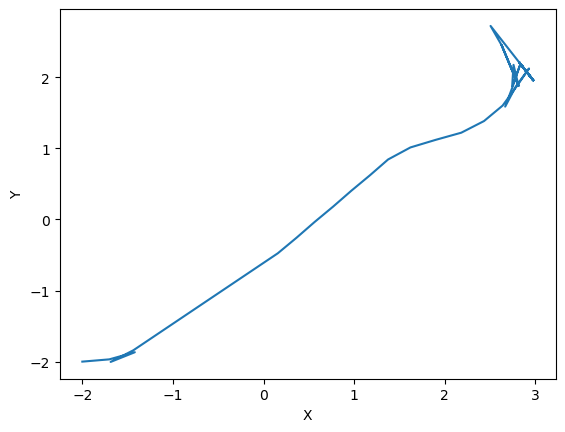

In [122]:
obs=np.array(best_obs)
obs=obs[:,[0,1]]
plt.plot(obs[:,0],obs[:,1])
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

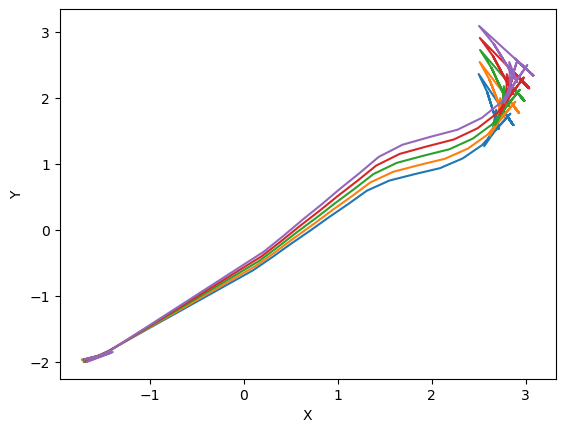

1.2220131257462228


In [123]:
pos=[]
for i in range(num_system):
    obs=np.array(best_pos[i])
    obs=obs[:,[0,1]]
    plt.plot(obs[:,0],obs[:,1])
    pos.append(obs[-1])
plt.xlabel('X')
plt.ylabel('Y')
plt.show()
print(reward_raw(np.array(pos)))

## Pure Exploitation Trajectory

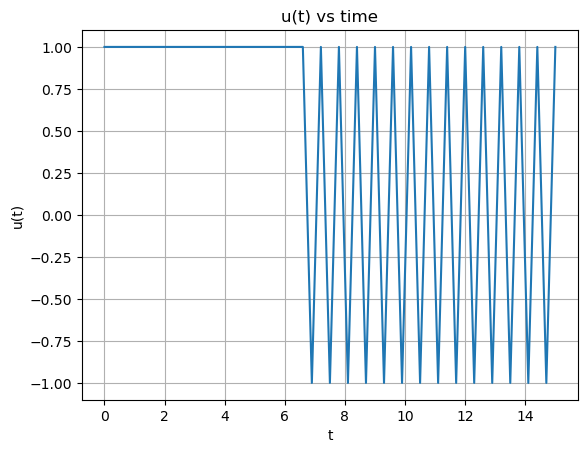

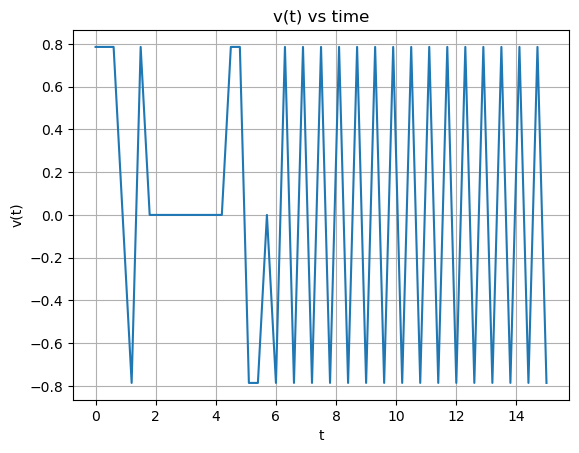

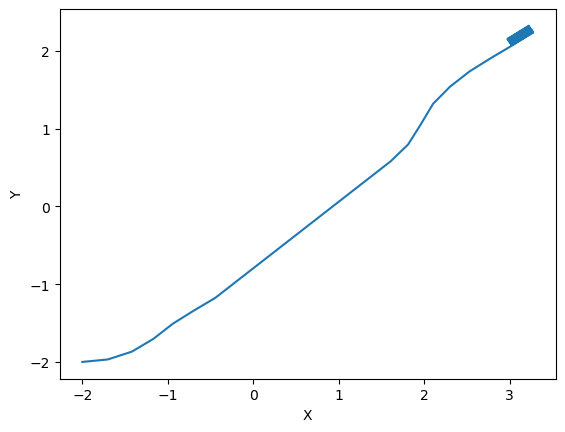

In [124]:
position=np.array([[-2,-2,0],[-2,-2,0],[-2,-2,0],[-2,-2,0],[-2,-2,0]])
observation=observe(position)
u_t=[]
observation_t=[observation]
position_t=[[] for i in range(5)]

for time in range(N+1):           
    candidates_u=[]
    for i in range(6):
        cand, _ = gpr_list[i].predict(observation.reshape(-1,5), return_std=True)
        candidates_u.append(cand[0])
    #print(candidates_u)
    u_k = decide_u_exploitation(observation,np.array(candidates_u))
    position_new = next_step(position,action_set[u_k])
    observation_new = observe(position_new)
    r = reward(observation_new)
    '''
    if explo:
        history_su[u_k] = np.concatenate((history_su[u_k], observation.reshape(-1,5)))
        history_r[u_k] = np.concatenate((history_r[u_k],np.array([r])))
    '''
    observation=observation_new
    position=position_new
    u_t.append(u_k)
    observation_t.append(observation)
    for i in range(num_system):
        position_t[i].append(position[i])
    '''
    if time%((N+1)//3+1)==0:
        for i in range(6):
            gpr_list[i]=GaussianProcessRegressor(alpha=1e-8).fit(history_su[i], history_r[i].reshape(-1,1))
    '''

    
u=[2*(0.5-i%2) for i in u_t]
v=[(1-i//2)*np.pi/4 for i in u_t]


x = np.linspace(0, T, N+1)
plt.plot(x, u)
plt.xlabel('t')
plt.ylabel('u(t)')
plt.title("u(t) vs time")
plt.grid()
plt.show()

x = np.linspace(0, T, N+1)
plt.plot(x, v)
plt.xlabel('t')
plt.ylabel('v(t)')
plt.title("v(t) vs time")
plt.grid()
plt.show()

obs=np.array(observation_t)
obs=obs[:,[0,1]]
plt.plot(obs[:,0],obs[:,1])
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

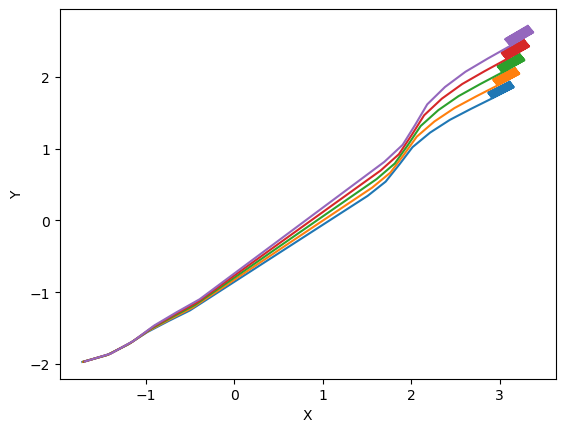

2.092107845402429


In [125]:
for i in range(num_system):
    obs=np.array(position_t[i])
    obs=obs[:,[0,1]]
    plt.plot(obs[:,0],obs[:,1])
plt.xlabel('X')
plt.ylabel('Y')
plt.show()
print(reward_raw(position))

In [126]:
print(observation_t[-1])
#print(position_t[-1][0])

[3.22053297 2.31952609 0.4712389  0.00528306 0.07565397]


In [127]:
a=[1,2,4,8]
a[1:3]

[2, 4]